# Training a dNN For Higgs Boson Detection From ATLAS Experiment Data From CERN

### Data Pre-processing:

In [1]:
import pandas as pd

In [3]:
train_df = pd.read_csv("training/training.csv")
test_df = pd.read_csv("test/test.csv")

print(train_df.shape)
train_df.head()

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [5]:
train_df.replace(-999.0, pd.NA, inplace=True)
test_df.replace(-999.0, pd.NA, inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

train_df.dropna(axis=1, thresh=int(0.9 * len(train_df)), inplace=True)
test_df.dropna(axis=1, thresh=int(0.9 * len(test_df)), inplace=True)

In [6]:
train_df["Label"] = train_df["Label"].str.strip().str.lower()
train_df["Label"] = train_df["Label"].map({'s': 1, 'b': 0})

feature_cols = [col for col in train_df.columns if col.startswith("DER_") or col.startswith("PRI_")]

X_test = test_df[feature_cols]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler!

In [26]:
from sklearn.model_selection import train_test_split

X_full = X_train_scaled
y_full = train_df["Label"].values
weights_full = train_df["Weight"].values

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_full, y_full, weights_full, test_size=0.2, random_state=42, stratify=y_full
)

## Training a Baseline Neural Network

### 5 hidden layers, 300 units, ReLU activation

In [54]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128)

In [51]:
import torch.nn as nn
import torch.optim as optim

class HiggsNet(nn.Module):
    def __init__(self, input_dim):
        super(HiggsNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = HiggsNet(X_train.shape[1])

In [11]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4417
Epoch 2/30, Loss: 0.4132
Epoch 3/30, Loss: 0.4066
Epoch 4/30, Loss: 0.4022
Epoch 5/30, Loss: 0.4003
Epoch 6/30, Loss: 0.3988
Epoch 7/30, Loss: 0.3974
Epoch 8/30, Loss: 0.3962
Epoch 9/30, Loss: 0.3958
Epoch 10/30, Loss: 0.3949
Epoch 11/30, Loss: 0.3946
Epoch 12/30, Loss: 0.3948
Epoch 13/30, Loss: 0.3945
Epoch 14/30, Loss: 0.3931
Epoch 15/30, Loss: 0.3937
Epoch 16/30, Loss: 0.3933
Epoch 17/30, Loss: 0.3932
Epoch 18/30, Loss: 0.3939
Epoch 19/30, Loss: 0.3928
Epoch 20/30, Loss: 0.3929
Epoch 21/30, Loss: 0.3920
Epoch 22/30, Loss: 0.3929
Epoch 23/30, Loss: 0.3929
Epoch 24/30, Loss: 0.3928
Epoch 25/30, Loss: 0.3931
Epoch 26/30, Loss: 0.3922
Epoch 27/30, Loss: 0.3914
Epoch 28/30, Loss: 0.3924
Epoch 29/30, Loss: 0.3921
Epoch 30/30, Loss: 0.3929


In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

model.eval()
with torch.no_grad():
    y_probs = []
    y_true = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_probs.extend(outputs.cpu().numpy())
        y_true.extend(labels.numpy())

# Flatten predictions and true labels
y_probs = [p[0] for p in y_probs]
y_preds = [1 if p > 0.5 else 0 for p in y_probs]  # Threshold at 0.5

# Metrics
accuracy = accuracy_score(y_true, y_preds)
auc = roc_auc_score(y_true, y_probs)
cm = confusion_matrix(y_true, y_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8330
AUC-ROC: 0.9033
Confusion Matrix:
[[29007  3860]
 [ 4492 12641]]


In [22]:
import numpy as np

def compute_ams(y_true, y_pred, weights, threshold=0.5, b_reg=10.0):
    y_pred_class = (y_pred > threshold).astype(int)
    
    s = weights[(y_true == 1) & (y_pred_class == 1)].sum()
    b = weights[(y_true == 0) & (y_pred_class == 1)].sum()
    
    ams = np.sqrt(2 * ((s + b + b_reg) * np.log(1.0 + s / (b + b_reg)) - s))
    return ams

In [34]:
y_probs = np.array(y_probs).reshape(-1)

ams = compute_ams(y_test, y_probs, w_test)

print(f"AMS Score: {ams:.4f}")

AMS Score: 1.2204


In [37]:
np.savez("deep_results.npz", y_probs=y_probs, y_true=y_test)

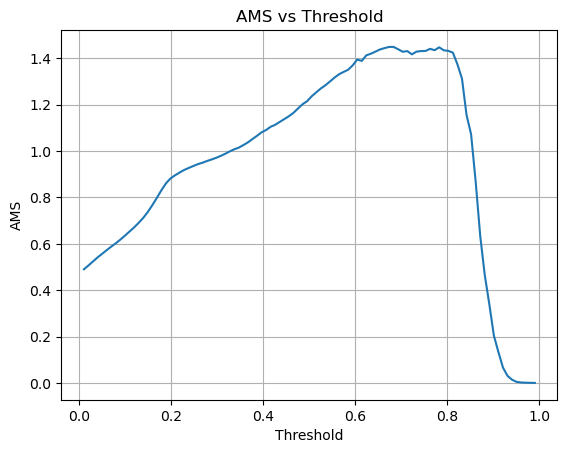

In [39]:
thresholds = np.linspace(0.01, 0.99, 100)
ams_scores = [compute_ams(y_test, y_probs, w_test, threshold=t) for t in thresholds]

plt.plot(thresholds, ams_scores)
plt.xlabel("Threshold")
plt.ylabel("AMS")
plt.title("AMS vs Threshold")
plt.grid(True)
plt.show()

In [40]:
best_index = np.argmax(ams_scores)
best_threshold = thresholds[best_index]
best_ams = ams_scores[best_index]

print(f"Best AMS: {best_ams:.4f} at threshold = {best_threshold:.3f}")

Best AMS: 1.4486 at threshold = 0.673


**Here we can see that the dNN is more cautious than the sNN, with a higher threshold**

In [42]:
y_final_preds = (y_probs > best_threshold).astype(int)

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final_preds))
print(classification_report(y_test, y_final_preds))

Accuracy: 0.80158
Confusion Matrix:
 [[31733  1134]
 [ 8787  8346]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86     32867
           1       0.88      0.49      0.63     17133

    accuracy                           0.80     50000
   macro avg       0.83      0.73      0.75     50000
weighted avg       0.82      0.80      0.78     50000



## Training on AMS Loss

In [46]:
import torch

class AMSLoss(nn.Module):
    def __init__(self, b_reg=10.0):
        super(AMSLoss, self).__init__()
        self.b_reg = b_reg

    def forward(self, y_pred, y_true, weights):
        y_pred = y_pred.float()
        y_true = y_true.float()
        weights = weights.float()

        y_pred = torch.clamp(y_pred, min=1e-7, max=1.0)

        s_mask = (y_true == 1).float()
        b_mask = (y_true == 0).float()

        s = torch.sum(weights * s_mask * y_pred)
        b = torch.sum(weights * b_mask * y_pred)

        radicand = 2 * ((s + b + self.b_reg) * torch.log1p(s / (b + self.b_reg)) - s)
        ams = torch.sqrt(torch.clamp(radicand, min=0.0))

        return -ams

In [61]:
bce_loss_fn = nn.BCELoss()
ams_loss_fn = AMSLoss()

In [62]:
model = HiggsNet(input_dim=X_train.shape[1])
model = model.to(device)

criterion = AMSLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
w_train_tensor = torch.tensor(w_train, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [64]:
ams_weight = 1.0
bce_weight = 0.1 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch, w_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        w_batch = w_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)

        ams_loss = ams_loss_fn(y_pred, y_batch, w_batch)
        bce_loss = bce_loss_fn(y_pred, y_batch)

        loss = ams_weight * ams_loss + bce_weight * bce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        train_probs = model(torch.tensor(X_train, dtype=torch.float32).to(device)).cpu().numpy().ravel()
        ams_val = compute_ams(y_train, train_probs, w_train)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | AMS: {ams_val:.4f}")

Epoch 1/30 | Loss: 17.2673 | AMS: 2.4335
Epoch 2/30 | Loss: 7.7243 | AMS: 2.4085
Epoch 3/30 | Loss: 5.3978 | AMS: 2.2973
Epoch 4/30 | Loss: 4.1881 | AMS: 2.3412
Epoch 5/30 | Loss: 3.1968 | AMS: 2.3415
Epoch 6/30 | Loss: 2.6622 | AMS: 2.3756
Epoch 7/30 | Loss: 2.4842 | AMS: 2.3410
Epoch 8/30 | Loss: 2.0097 | AMS: 2.3577
Epoch 9/30 | Loss: 1.8031 | AMS: 2.3728
Epoch 10/30 | Loss: 1.4574 | AMS: 2.3982
Epoch 11/30 | Loss: 1.5693 | AMS: 2.3117
Epoch 12/30 | Loss: 1.2443 | AMS: 2.3705
Epoch 13/30 | Loss: 1.1531 | AMS: 2.3322
Epoch 14/30 | Loss: 1.3216 | AMS: 2.4416
Epoch 15/30 | Loss: 0.7265 | AMS: 2.3517
Epoch 16/30 | Loss: 0.8045 | AMS: 2.3376
Epoch 17/30 | Loss: 1.0233 | AMS: 2.2914
Epoch 18/30 | Loss: 0.7146 | AMS: 2.3109
Epoch 19/30 | Loss: 0.7452 | AMS: 2.4101
Epoch 20/30 | Loss: 0.7927 | AMS: 2.4082
Epoch 21/30 | Loss: 0.8045 | AMS: 2.4025
Epoch 22/30 | Loss: 0.4202 | AMS: 2.4112
Epoch 23/30 | Loss: 0.5302 | AMS: 2.3840
Epoch 24/30 | Loss: 0.6107 | AMS: 2.3858
Epoch 25/30 | Loss: 0.42

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

model.eval()
with torch.no_grad():
    y_probs = []
    y_true = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_probs.extend(outputs.cpu().numpy())
        y_true.extend(labels.numpy())

# Flatten predictions and true labels
y_probs = [p[0] for p in y_probs]
y_preds = [1 if p > 0.5 else 0 for p in y_probs]  # Threshold at 0.5

# Metrics
accuracy = accuracy_score(y_true, y_preds)
auc = roc_auc_score(y_true, y_probs)
cm = confusion_matrix(y_true, y_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8205
AUC-ROC: 0.8967
Confusion Matrix:
[[27115  5752]
 [ 3224 13909]]


In [66]:
y_probs = np.array(y_probs).reshape(-1)

ams = compute_ams(y_test, y_probs, w_test)

print(f"AMS Score: {ams:.4f}")

AMS Score: 1.1602


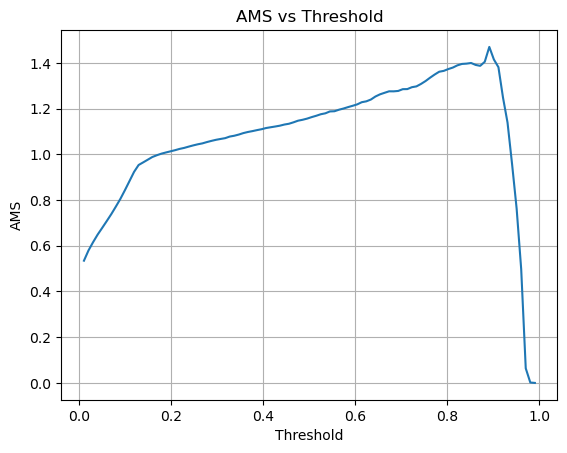

In [67]:
thresholds = np.linspace(0.01, 0.99, 100)
ams_scores = [compute_ams(y_test, y_probs, w_test, threshold=t) for t in thresholds]

plt.plot(thresholds, ams_scores)
plt.xlabel("Threshold")
plt.ylabel("AMS")
plt.title("AMS vs Threshold")
plt.grid(True)
plt.show()

In [68]:
best_index = np.argmax(ams_scores)
best_threshold = thresholds[best_index]
best_ams = ams_scores[best_index]

print(f"Best AMS: {best_ams:.4f} at threshold = {best_threshold:.3f}")

Best AMS: 1.4698 at threshold = 0.891


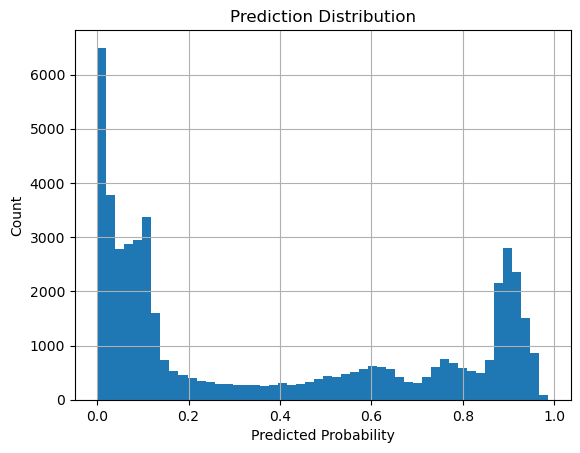

In [69]:
import matplotlib.pyplot as plt
plt.hist(y_probs, bins=50)
plt.title("Prediction Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [70]:
np.savez("ams_loss_results.npz", y_probs=y_probs, y_true=y_test)